# Analysis of mouse retinal transcriptomic data (GLDS-203): Low dose irradiation and hindlimb unloading microgravity in mice

- Project: TRRaC
- Author: Prachi Kothiyal
- Last modified on: 07/29/2022

## Summary
GeneLab dataset GLDS-203 is obtained from a ground-based experiment that uses rodent models to evaluate damage in eye induced by prolonged low-dose radiation and simulated microgravity. Here, we analyze RNA sequencing from female mice subjected to irradiation and/or microgravity with tissues collected at 7 days, 1 or 4 month following exposure to radiation and/or microgravity.

## Dataset
- Raw unnormalized counts: https://genelab-data.ndc.nasa.gov/genelab/accession/GLDS-203/ (version 6)

In [ ]:
#Load libraries
options(warn=-1)
library(data.table)
library(cowplot)
library(ggplot2)
library(ggnewscale)
library(ggridges)
library(pheatmap)
library(viridisLite)
library(IRdisplay)
library(dplyr)
library(tidyverse)
organism="org.Mm.eg.db"
library(organism, character.only = TRUE)
library(data.table)
library(IRkernel)
library(repr)
library(DESeq2)
library(RColorBrewer)
library(plyr)
library(BiocParallel)
library(biomaRt)
library(scales)
library(ComplexUpset)

In [2]:
#Set workdir and theme for ggplot2
setwd("/home/jupyter/MOUNT/integrated")
theme_set(theme_bw() + theme(axis.text=element_text(size=20),axis.title=element_text(size=20, face="bold"), 
                             plot.title = element_text(size=20, face="bold"), plot.subtitle = element_text(size=16)))

In [ ]:
#Extract gene biotypes and gene names from Biomart
httr::set_config(httr::config(ssl_verifypeer = FALSE))
mart <- useMart('ENSEMBL_MART_ENSEMBL')
mart <- useDataset('mmusculus_gene_ensembl', mart)

annotLookup <- getBM(
  mart = mart,
  attributes = c(
    'ensembl_gene_id',
    'ensembl_transcript_id',
    'external_gene_name',
    'gene_biotype'),
  uniqueRows = TRUE)

### Data pre-processing

In [4]:
#Load unnormalized counts and perform filtering, normalization and VST for global PCA; differential expression analysis will 
#be performed for each timepoint/group separately.
counts<-as.data.frame(read.delim("GLDS-203_rna_seq_Unnormalized_Counts.csv",sep=",",row.names=1,header=TRUE)) 
counts <- counts %>% dplyr::filter(!grepl("ERCC",row.names(counts))) %>%
            dplyr::select(-c(`Mmus_C57_6J_RTN_HLLC_IRC_4mon_Rep4_M97`, `Mmus_C57_6J_RTN_HLLC_IRC_7d_Rep2_M12`,
                            `Mmus_C57_6J_RTN_HLU_IRC_4mon_Rep5_M93`))
coldata<-read.delim("coldata.tsv",row.names=1,header=TRUE) %>% 
            dplyr::filter(SampleName!="Mmus_C57_6J_RTN_HLLC_IRC_4mon_Rep4_M97" & SampleName!="Mmus_C57_6J_RTN_HLLC_IRC_7d_Rep2_M12"
                         & SampleName!="Mmus_C57_6J_RTN_HLU_IRC_4mon_Rep5_M93") %>%
            dplyr::mutate(Group = fct_relevel(Group, "Control", "HLU", "IR","HLU_IR"), Timepoint=fct_relevel(Timepoint, "7d", "1m","4m"))

#Filter genes based on biotype
genesCounts<-as.data.frame(row.names(counts))
genesCoding<-unique(as.data.frame(subset(annotLookup, gene_biotype=="protein_coding" | grepl("RNA",gene_biotype), select=c("ensembl_gene_id"))))
colnames(genesCounts) <- colnames(genesCoding) <-c("gene")
merged<-merge(genesCounts,genesCoding,by=c("gene"))

counts <- counts[merged$gene,unique(rownames(coldata))]
all(colnames(counts) == rownames(coldata))
ddsNofilt <- DESeqDataSetFromMatrix(countData = round(counts), colData=coldata, 
                                    design=~Group+Timepoint)
ddply(coldata,.(Timepoint,Group),nrow)

#Normalize and filter low count genes
ddsNofilt <- estimateSizeFactors(ddsNofilt)
keep <- rowSums(counts(ddsNofilt) >= 5 ) >= 3
dds <- ddsNofilt[keep,]
#Use variance stabilizing tranformed data for clustering and PCA
vsd <- vst(dds, blind = TRUE)

[1] TRUE

converting counts to integer mode



Timepoint,Group,V1
<fct>,<fct>,<int>
7d,Control,5
7d,HLU,4
7d,IR,5
7d,HLU_IR,6
1m,Control,5
1m,HLU,5
1m,IR,6
1m,HLU_IR,4
4m,Control,3


### PCA using global gene expression data (Supplementary Figure 1A)

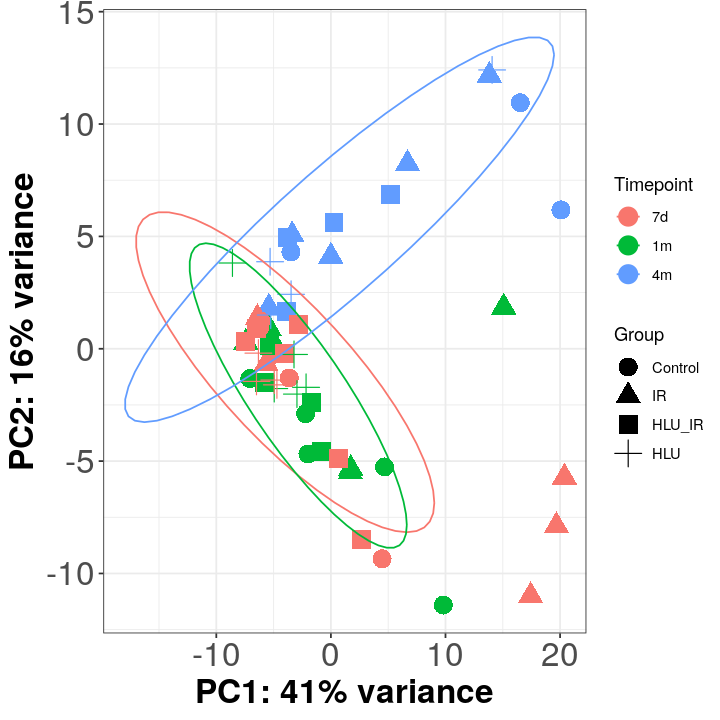

In [6]:
#PCA based on global gene expression
pcaData<-plotPCA(vsd, intgroup = c("Timepoint","Group"), returnData=TRUE) %>% 
            dplyr::mutate(Group = fct_relevel(Group, "Control", "IR","HLU_IR"), Timepoint=fct_relevel(Timepoint, "7d", "1m","4m"))

percentVar <- round(100 * attr(pcaData, "percentVar")) 

options(repr.plot.width=6, repr.plot.height=6)
overallPCA<-ggplot(pcaData, aes(x = PC1, y = PC2, color = Timepoint, shape = Group, group=Timepoint)) + 
geom_point(size =5) + 
xlab(paste0("PC1: ", percentVar[1], "% variance")) + 
ylab(paste0("PC2: ", percentVar[2], "% variance")) + stat_ellipse()
print(overallPCA)

### Differential gene expression analysis

In [ ]:
#Differential gene expression analysis for exposure vs. control groups within each timepoint; filtering and normalization are
#performed within each group instead of across all timepoins to retain genes specific to a given timepoint.
timepoints<-c("7d","1m","4m")
cases<-c("HLU","IR","HLU_IR")
par(mfrow=c(3,3))
k=0
for (i in 1:length(timepoints)){
    for (j in 1:length(cases)){
        k=k+1
        ddsGroup<-ddsNofilt[,(ddsNofilt$Group %in% c("Control",cases[j]) & ddsNofilt$Timepoint %in% c(timepoints[i]))]
        print(dim(ddsGroup))
        ddsGroup <- estimateSizeFactors(ddsGroup)
        keep <- rowSums(counts(ddsGroup, normalized=TRUE) >= 5) >= 3
        ddsGroup <- ddsGroup[keep,]
        print(dim(ddsGroup))
        ddsGroup$group <- factor(ddsGroup$Group)
        design(ddsGroup) <- ~group
        ddsGroup <- DESeq(ddsGroup)
        
        res <- results(ddsGroup, contrast=c("group",cases[j],"Control"))
        res$type<-ifelse(!is.na(res$padj) & res$padj<=0.05 & res$log2FoldChange>0.263, "possig", ifelse(!is.na(res$padj) & res$padj<=0.05 & res$log2FoldChange< -0.263,"negsig","notsig"))
        upReg<-dim(subset(res,type=="possig"))[1]
        downReg<-dim(subset(res,type=="negsig"))[1]
        p<-ggplot(as.data.frame(subset(res,!is.na(padj)))) + geom_point(aes(x=log2FoldChange,y=-log10(padj),
                color=as.factor(type)),size=1) + 
                scale_color_manual(values=c("negsig"="blue","notsig"="darkgray","possig"="red")) + ggtitle(paste0(timepoints[i]," ",cases[j],"\n","Up: ",upReg,", Down: ",downReg)) + 
                theme(legend.position = "none") +
                labs(title=paste0(timepoints[i]," ",cases[j]), subtitle=paste0("Up: ",upReg,", Down: ",downReg),x=expression(bold(Log[2](fold~change))), y=expression(bold(atop(-Log[10],(adj~p-value))))) +
                geom_hline(yintercept=-log10(0.05), linetype="dashed", color="darkgreen", size=1) + 
                geom_vline(xintercept=0.263,linetype="dashed", color="darkgreen", size=1) + geom_vline(xintercept=-0.263, linetype="dashed", color="darkgreen", size=1)
         assign(paste0("p",k), p)
        
        print(ddply(as.data.frame(res),.(type),nrow))
        res$ensembl<-row.names(res)
        res$Group<-paste0(timepoints[i]," ",cases[j])
        
        if(k==1){
            outputTable=res
        }
        else{
            outputTable=rbind(outputTable,res)
        }
    }
}
write.table(outputTable, "GLDS-203_deg.tsv", quote=FALSE, row.names=F, sep="\t")

### Volcano plots, heatmaps and upset plots based on DEG (Figure 1)

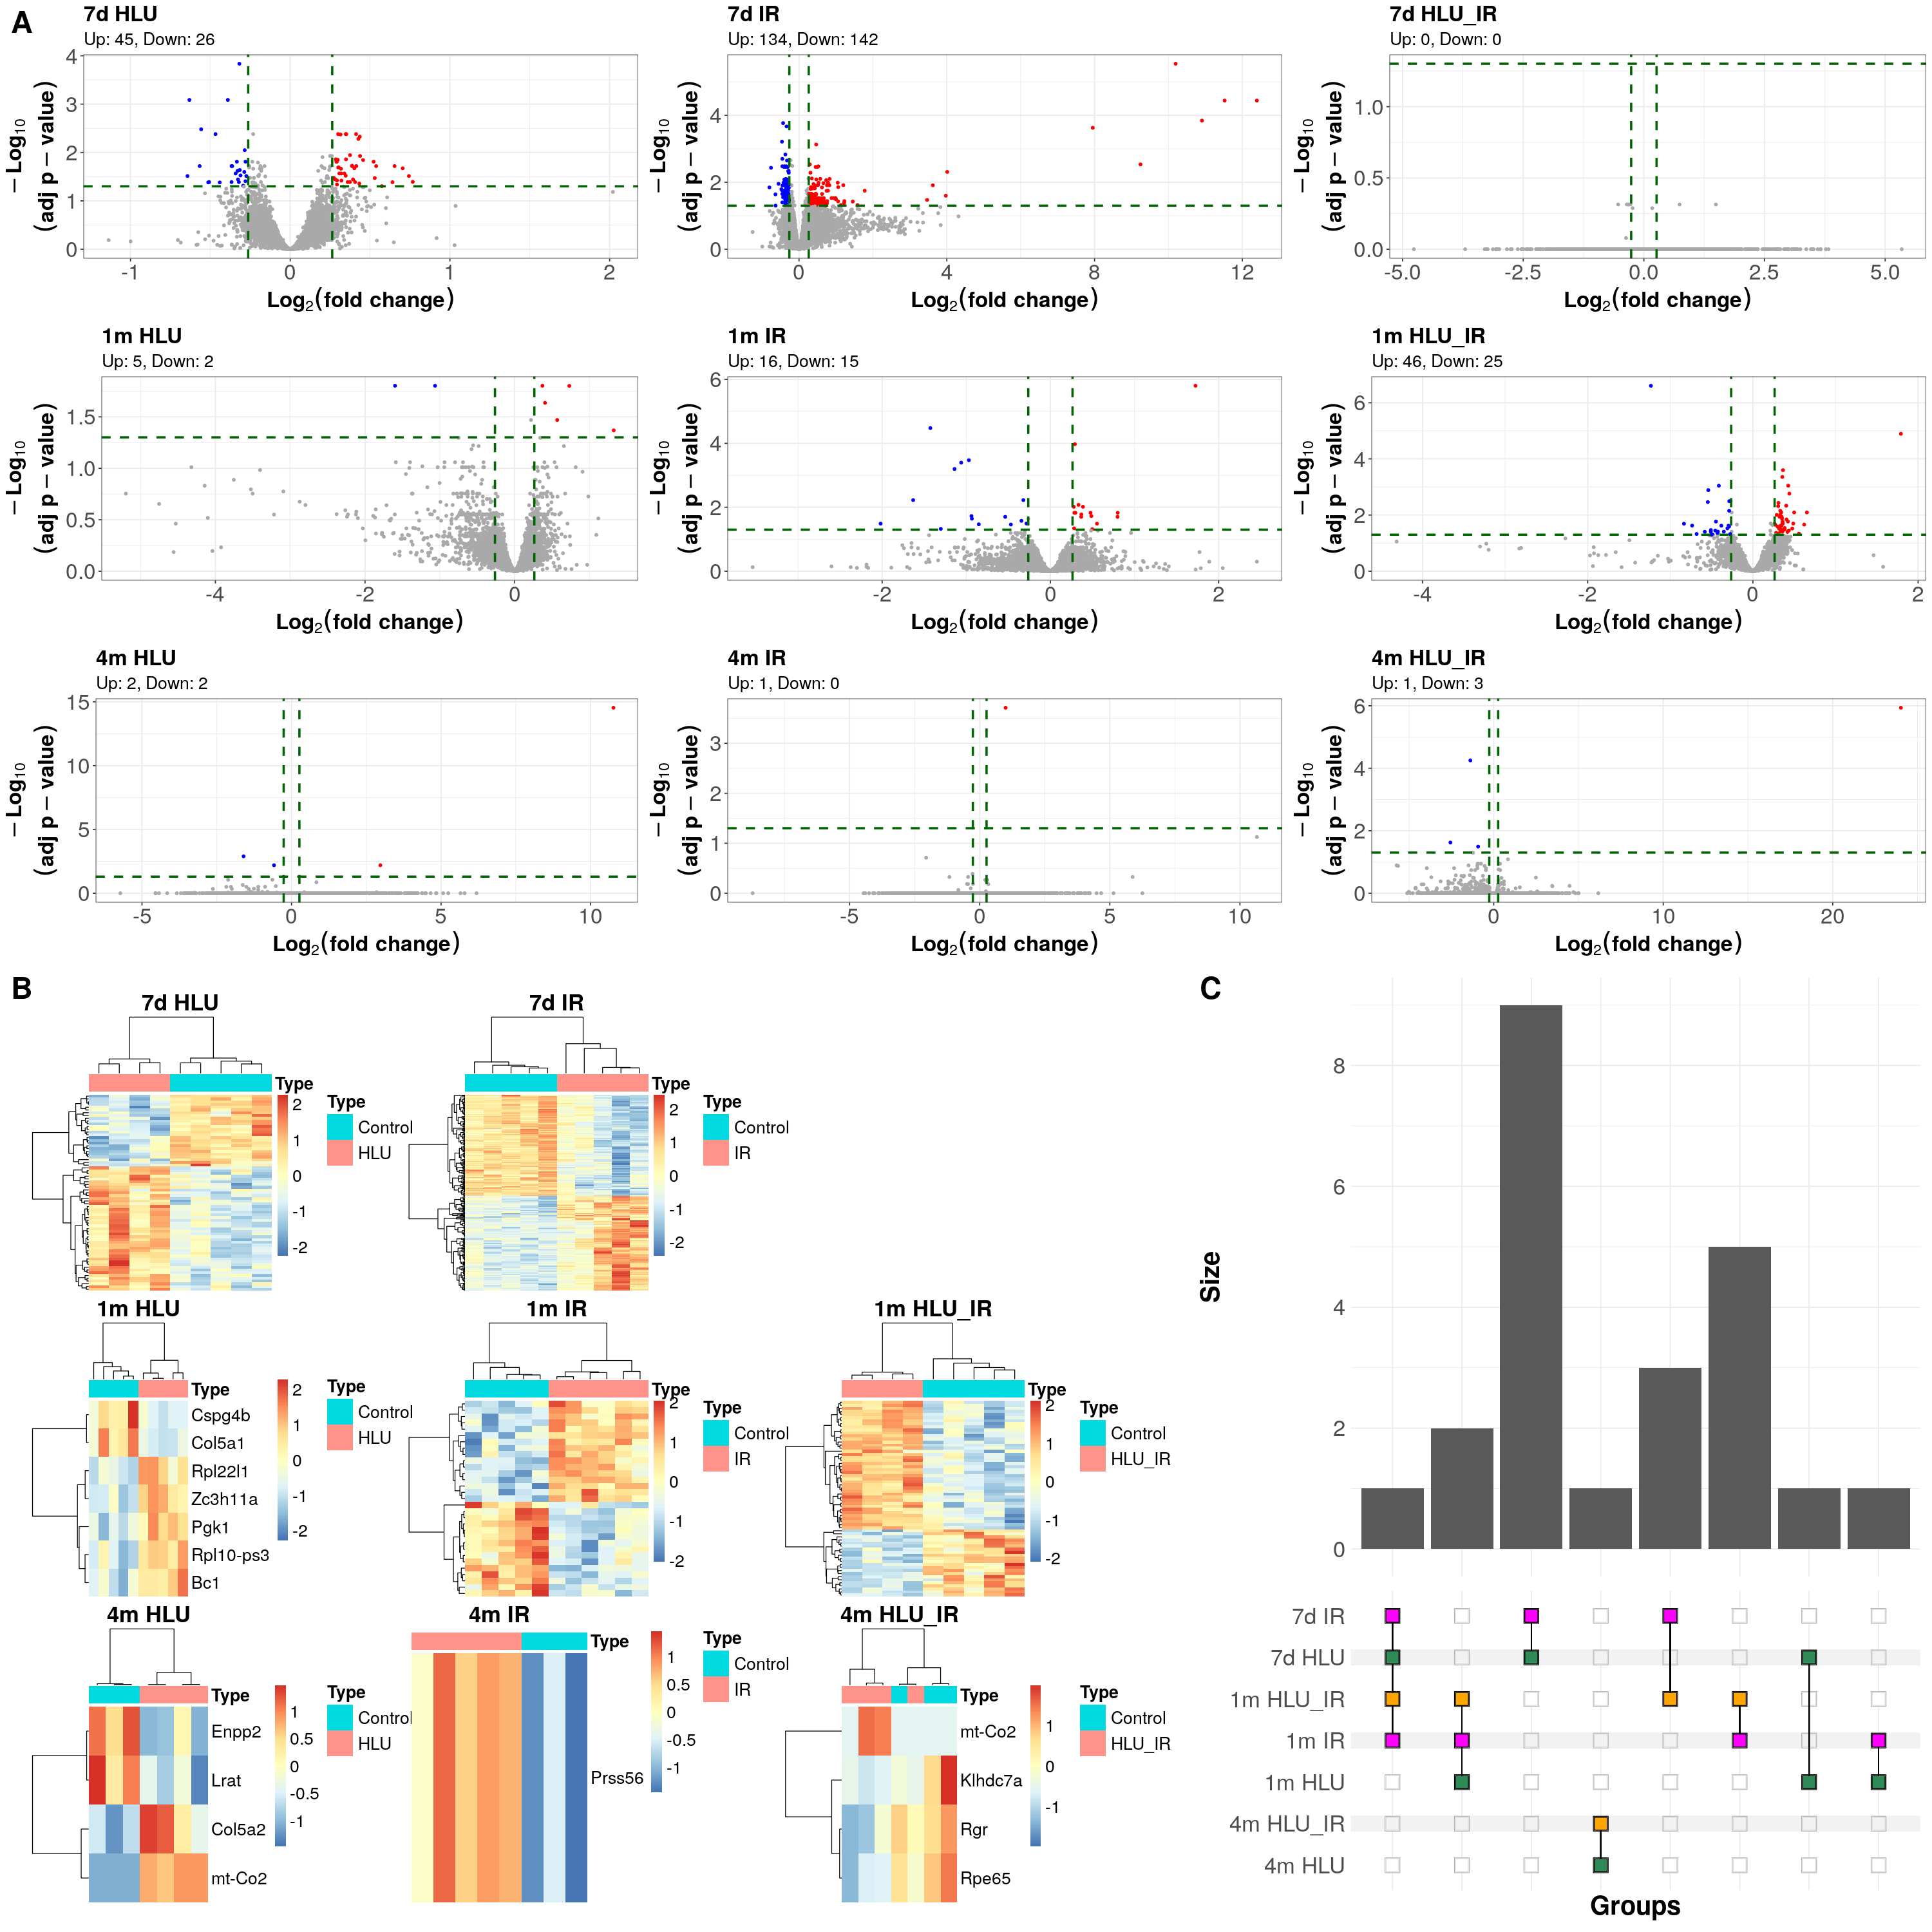

In [16]:
#Create Figure 1 (volcano plots, heatmaps and upset plots)
options(repr.plot.width=5, repr.plot.height=5)
degs<-fread("GLDS-203_deg.tsv",header=T)
cases<-c("HLU","IR","HLU_IR")
k=0
options(repr.plot.width=25, repr.plot.height=25)
for (i in 1:length(timepoints)){
  for (j in 1:length(cases)){
      genes<-subset(degs,(type=="possig" | type=="negsig") & Group==paste0(timepoints[i]," ",cases[j]))
      if(dim(genes)[1]>0){
        genesAnno<-merge(subset(genes,select=c("ensembl")),unique(subset(annotLookup,select=c("ensembl_gene_id","external_gene_name"))),
                        by.x=c("ensembl"),by.y=c("ensembl_gene_id"))
        vsdSub <- vsd[genesAnno$ensembl,
                    (vsd$Group %in% c("Control",cases[j]) & vsd$Timepoint %in% c(timepoints[i]))]
        rownames(vsdSub)<-genesAnno$external_gene_name
        labels <- as.data.frame(vsdSub$SampleName)
        labels$Group<-paste(vsdSub$Group,sep=" ")
        colnames(labels)<-c("name","Type")
        labels <- labels %>% dplyr::select(name,Type) %>% column_to_rownames(var="name") %>% dplyr::select(Type)
        k=k+1
          if(dim(genes)[1]<2){
            p<-pheatmap(assay(vsdSub),annotation_col=labels,scale="row",fontsize = 16,cluster_rows=FALSE,cluster_cols=FALSE,
                         border_color = NA,show_colnames=FALSE,silent=TRUE,main=paste0(timepoints[i]," ",cases[j]))
              assign(paste0("ph",k), p)
              }
          else if (dim(genes)[1]>10){
              p<-pheatmap(assay(vsdSub),annotation_col=labels,scale="row",fontsize = 16,show_rownames=FALSE,
                          clustering_distance_rows = "correlation",clustering_distance_cols = "correlation",
                         border_color = NA,show_colnames=FALSE,silent=TRUE,main=paste0(timepoints[i]," ",cases[j]))
              assign(paste0("ph",k), p)
              }
          else{
              p<-pheatmap(assay(vsdSub),annotation_col=labels,scale="row",fontsize = 16,
                          clustering_distance_rows = "correlation",clustering_distance_cols = "correlation",
                         border_color = NA,show_colnames=FALSE,silent=TRUE,main=paste0(timepoints[i]," ",cases[j]))
              assign(paste0("ph",k), p)
              }
          
          genesAnno$Group<-paste0(timepoints[i]," ",cases[j])
          if(k==1){
              allDegs<-subset(genesAnno,select=c("external_gene_name","Group"))
          }
          else{
              allDegs<-rbind(allDegs,subset(genesAnno,select=c("external_gene_name","Group")))
          }
          
          }
      }
    }

dfDegs<-dcast(allDegs, external_gene_name~Group, length)
Groups = colnames(dfDegs)[2:9]
p_upset<-upset(dfDegs, Groups, name='Groups', width_ratio=0.1, min_size=0, min_degree=2, set_sizes=FALSE,
      queries=list(
        upset_query(set='7d HLU', fill='seagreen'),
        upset_query(set='7d IR', fill='magenta'),
        upset_query(set='1m HLU', fill='seagreen'),
        upset_query(set='1m IR', fill='magenta'),
        upset_query(set='1m HLU_IR', fill='orange'),
        upset_query(set='4m HLU', fill='seagreen'),
        upset_query(set='4m IR', fill='magenta'),
        upset_query(set='4m HLU_IR', fill='orange')
      ),
      themes=upset_default_themes(text=element_text(size=26), axis.title=element_text(face="bold",size=24)),
      sort_intersections_by='degree',
      base_annotations=list('Size'=(intersection_size(counts=FALSE)) + scale_y_continuous(breaks = pretty_breaks())),
       matrix=intersection_matrix(
          geom=geom_point(shape='square filled',size=6)
  )
)

plot_grid(
    plot_grid(plot_grid(p1,p2,p3,p4,p5,p6,p7,p8,p9,ncol=3),labels=c("A"),ncol=1,label_size=28),
    plot_grid(plot_grid(ph1$gtable,ph2$gtable,NULL,ph3$gtable,ph4$gtable,ph5$gtable,ph6$gtable,ph7$gtable,ph8$gtable,nrow=3),p_upset,labels=c("B","C"),label_size=28,ncol=2,rel_widths=c(1.2,0.75),scale=c(0.95,1)),
    nrow=2)

### Clustering based on DEGs in HLU vs. IR (Supplementary Figure 1B)

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



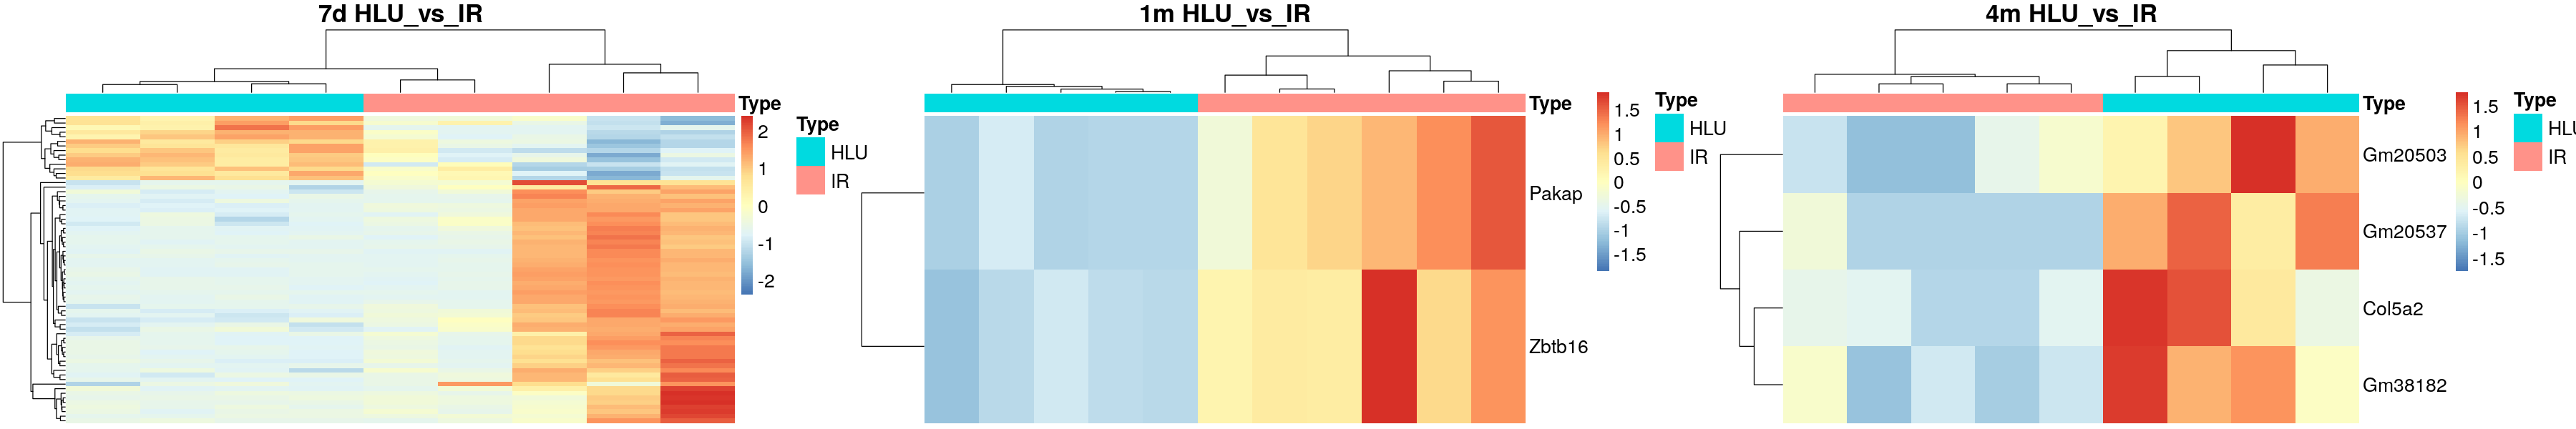

In [8]:
#Supplementary Figure 1B (clustering using DEGs between HLU vs. IR for each timepoint)
cases<-c("IR")
timepoints<-c("7d","1m","4m")
degs<-fread("GLDS-203_deg.tsv",header=T)
k=0
options(repr.plot.width=25, repr.plot.height=25)
for (i in 1:length(timepoints)){
  for (j in 1:length(cases)){
        ddsGroup<-ddsNofilt[,(ddsNofilt$Group %in% c("HLU",cases[j]) & ddsNofilt$Timepoint %in% c(timepoints[i]))]
        ddsGroup <- estimateSizeFactors(ddsGroup)
        keep <- rowSums(counts(ddsGroup, normalized=TRUE) >= 5) >= 1
        ddsGroup <- ddsGroup[keep,]
        ddsGroup$group <- factor(ddsGroup$Group)
        design(ddsGroup) <- ~group
        ddsGroup <- DESeq(ddsGroup)
        
        res <- results(ddsGroup, contrast=c("group",cases[j],"HLU"))
        res$type<-ifelse(!is.na(res$padj) & res$padj<=0.05 & res$log2FoldChange>0.263, "possig", ifelse(!is.na(res$padj) & res$padj<=0.05 & res$log2FoldChange< -0.263,"negsig","notsig"))
        res$ensembl<-row.names(res)
        res$Group<-paste0(timepoints[i]," ",cases[j])
        genes<-subset(as.data.frame(res),type=="possig" | type=="negsig")
      
      if(dim(genes)[1]>0){
        genesAnno<-merge(subset(genes,select=c("ensembl")),unique(subset(annotLookup,select=c("ensembl_gene_id","external_gene_name"))),
                        by.x=c("ensembl"),by.y=c("ensembl_gene_id"))
        vsdSub <- vsd[genesAnno$ensembl,
                    (vsd$Group %in% c("HLU",cases[j]) & vsd$Timepoint %in% c(timepoints[i]))]
        rownames(vsdSub)<-genesAnno$external_gene_name
        labels <- as.data.frame(vsdSub$SampleName)
        labels$Group<-paste(vsdSub$Group,sep=" ")
        colnames(labels)<-c("name","Type")
        labels <- labels %>% dplyr::select(name,Type) %>% column_to_rownames(var="name") %>% dplyr::select(Type)
        k=k+1
          if(dim(genes)[1]<2){
            p<-pheatmap(assay(vsdSub),annotation_col=labels,scale="row",fontsize = 16,cluster_rows=FALSE,cluster_cols=FALSE,
                         border_color = NA,show_colnames=FALSE,silent=TRUE,main=paste0(timepoints[i]," ","HLU_vs_",cases[j]))
              assign(paste0("phHLUvsIR",k), p)
              }
          else if (dim(genes)[1]>10){
              p<-pheatmap(assay(vsdSub),annotation_col=labels,scale="row",fontsize = 16,show_rownames=FALSE,
                         border_color = NA,show_colnames=FALSE,silent=TRUE,main=paste0(timepoints[i]," ","HLU_vs_",cases[j]))
              assign(paste0("phHLUvsIR",k), p)
              }
          else{
              p<-pheatmap(assay(vsdSub),annotation_col=labels,scale="row",fontsize = 16,
                         border_color = NA,show_colnames=FALSE,silent=TRUE,main=paste0(timepoints[i]," ","HLU_vs_",cases[j]))
              assign(paste0("phHLUvsIR",k), p)
              }
          }
      }
    }
options(repr.plot.width=30, repr.plot.height=5)
plot_grid(phHLUvsIR1$gtable,phHLUvsIR2$gtable,phHLUvsIR3$gtable,ncol=3)

In [10]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.3.5.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ComplexUpset_1.3.3          scales_1.2.0               
 [3] biomaRt_2.50.3              BiocParallel_1.28.3        
 [5] plyr_1.8.6                  RColorBrewer_1.1-2         
 [7] DESeq2_1.34.0               SummarizedExperiment_1.24.0
 [9] MatrixGenerics_1.6.0        matrixStats_0.62.0         
